# Dataset Splitter mechanics

This notebook will make use of dataset's split method and why use it to get balanced datasets

The goal is to split a dataset into train and valid which are respectively 90% and 10% of the dataset (image wise)

In [1]:
%load_ext autoreload

%autoreload 2
from libia.dataset import from_coco
from libia.dataset.split.balanced_groups import df_to_hist
from libia.utils import grouper

import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from ot import emd2, sinkhorn2, dist

pd.set_option("max_colwidth", 20)

## Example setup

This will be used as an example

Some splitting methods can be slow (could be sped up with multiprocessing, stay tuned !) so we keep the dataset small for this example

In [2]:
coco_valid = "notebook_data/coco_valid.json"
COCO_dataset = from_coco(coco_valid, images_root=".")
COCO_SC = COCO_dataset.remap_from_preset("coco", "supercategory").iloc_annot[::10]

In [3]:
COCO_SC

## Let's check the data repartition for categories and box heights
   
Notice the check_split_conformity will compare different splits. A big overlap between the different histogram will mean balanced splits

In [4]:
bins = range(0, 600, 50)


def check_split_conformity(dataset):
    plt.figure()
    seaborn.histplot(
        dataset.annotations,
        x="box_height",
        stat="density",
        hue="split",
        common_norm=False,
        bins=bins,
    )

    plt.figure()
    seaborn.histplot(
        dataset.annotations,
        x="category_str",
        stat="density",
        hue="split",
        common_norm=False,
    )
    plt.xticks(rotation=45)
    plt.show()

    person_sedan = dataset.annotations[
        COCO_SC.annotations["category_str"].isin(["person", "vehicle"])
    ]
    plt.figure()
    seaborn.displot(
        person_sedan,
        x="box_height",
        col="category_str",
        hue="split",
        stat="density",
        common_norm=False,
        bins=bins,
    )
    plt.show()

    cutted = (
        pd.cut(dataset.annotations["box_height"], bins=bins)
        .apply(lambda x: x.left)
        .astype(float)
    )
    target_hist = dataset.annotations.groupby(cutted).size()
    for split, group in dataset.annotations.groupby("split"):
        cutted = (
            pd.cut(group["box_height"], bins=bins).apply(lambda x: x.left).astype(float)
        )
        candidate_hist = dataset.annotations.groupby(cutted).size()
        left_bins = target_hist.index.to_numpy()
        right_bins = candidate_hist.index.to_numpy()
        distance_matrix = dist(
            left_bins[:, None], right_bins[:, None], metric="cityblock"
        )
        distance_matrix = distance_matrix / distance_matrix.max()

        normalized_left = (target_hist / target_hist.sum()).to_numpy()
        normalized_right = (candidate_hist / candidate_hist.sum()).to_numpy()
        emd = emd2(normalized_left, normalized_right, distance_matrix)
        sinkhorn = sinkhorn2(
            normalized_left, normalized_right, distance_matrix, reg=1e-1
        )
        print(
            f"EMD and sinkhorn between target and {split} for box height :"
            f" {emd} {sinkhorn}"
        )

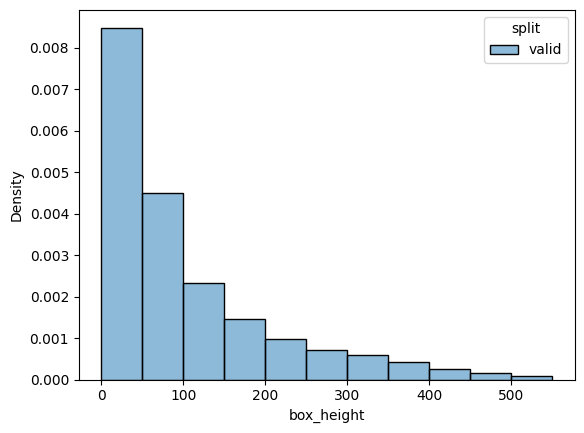

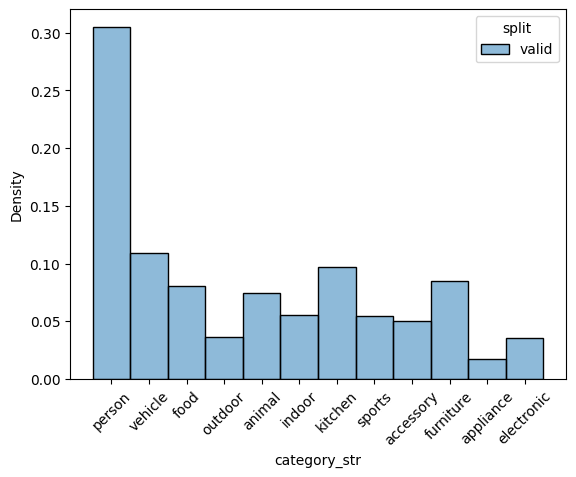

<Figure size 640x480 with 0 Axes>

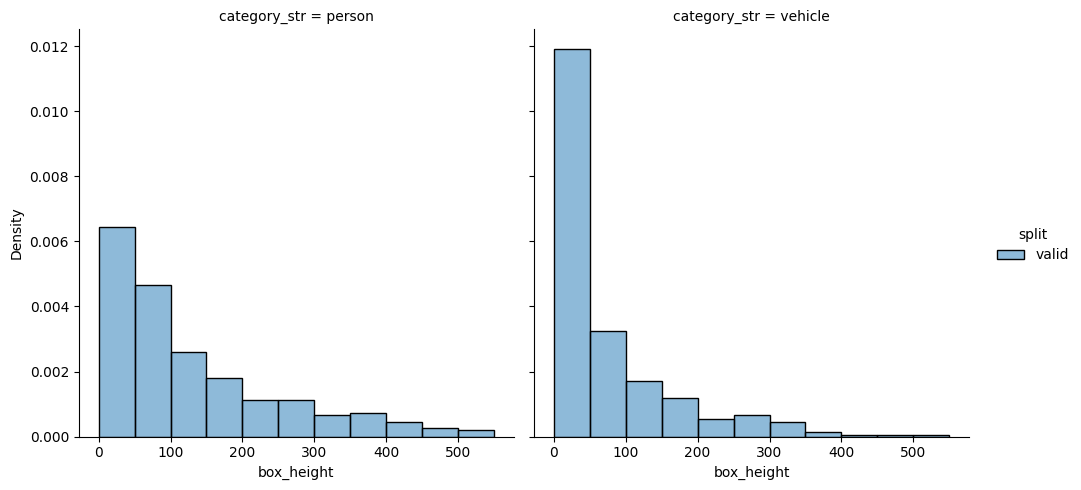

EMD and sinkhorn between target and valid for box height : 0.0 0.05641091212724669


In [5]:
check_split_conformity(COCO_SC)

## First split try with the most naive way : split dataset dataset in 90%/10% completely randomly and hope for the best

In [6]:
COCO_SC.images.split = None
splitted_COCO_naive = COCO_SC.split(
    input_seed=0,
    split_names=["train", "valid"],
    target_split_shares=[0.9, 0.1],
    keep_separate_groups=["image_id"],
    keep_balanced_groups=[],
)

Using simple random split


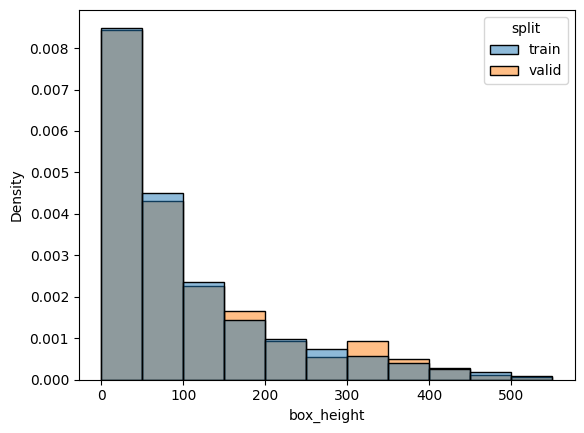

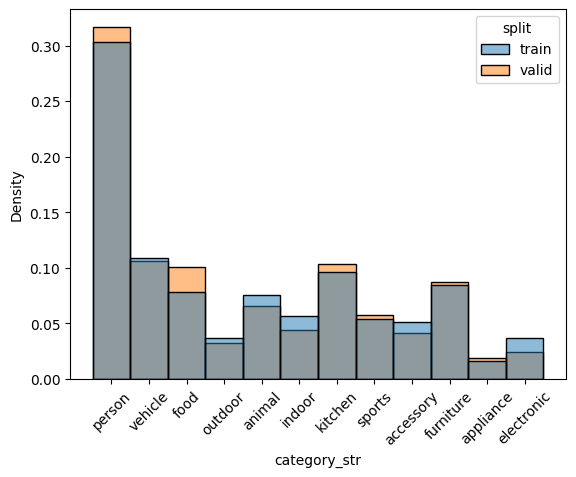

<Figure size 640x480 with 0 Axes>

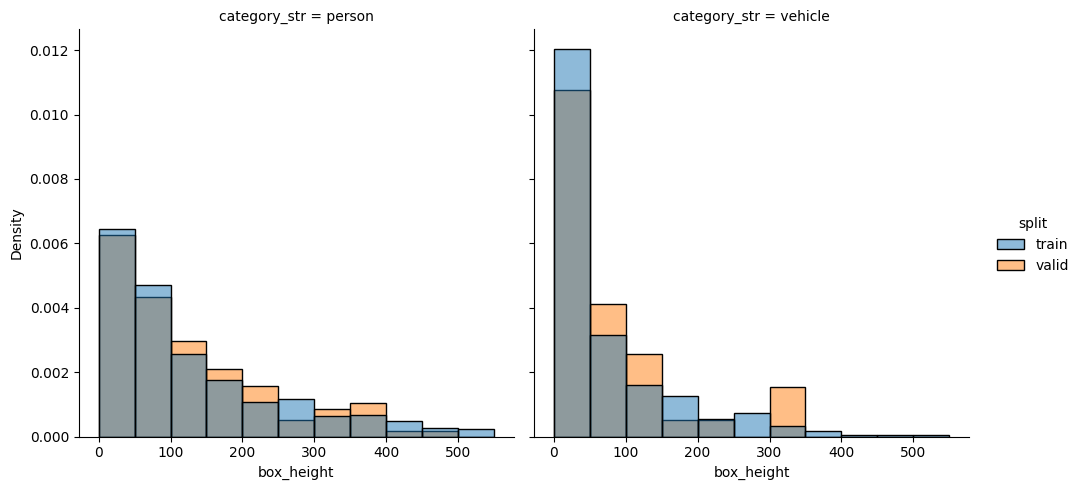

EMD and sinkhorn between target and train for box height : 0.0008374786384173133 0.056398522126405976
EMD and sinkhorn between target and valid for box height : 0.007599599545307657 0.057616027043828816


In [7]:
check_split_conformity(splitted_COCO_naive)

Splitted dataset is not too bad, but we can do better, especially for classes. For example, `electronic` is not well represented in train split.

## Split while keeping categories balanced

Now, we can try with "category_id" as dataset class we want to keep balanced. Note that this is the default behaviour.

In [8]:
splitted_COCO_balanced_category = COCO_SC.split(
    input_seed=1,
    split_names=["train", "valid"],
    target_split_shares=[0.9, 0.1],
    keep_separate_groups=["image_id"],
    keep_balanced_groups=["category_id"],
    share_cost_weight=0,
)

Splitting annotations ...
Separating input data into atomic chunks
2699 chunks to distribute across 2 splits


  0%|          | 0/2699 [00:00<?, ?it/s]

Splitting images ...
Separating input data into atomic chunks
2301 chunks to distribute across 2 splits


  0%|          | 0/2301 [00:00<?, ?it/s]

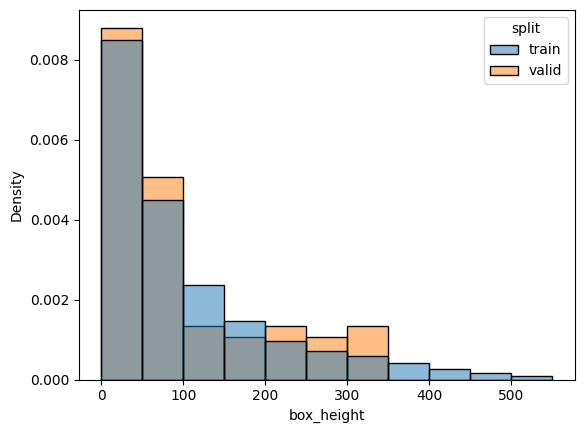

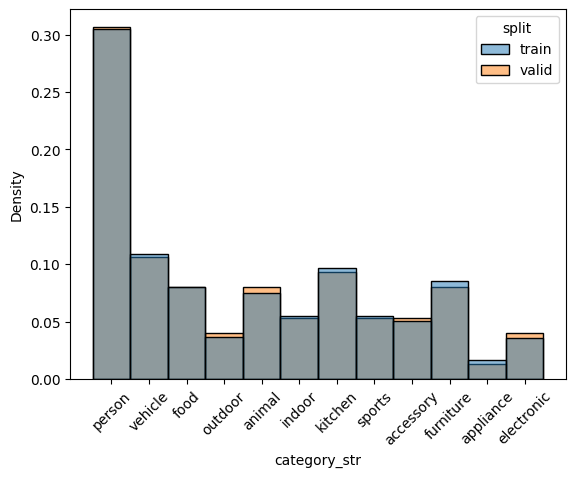

<Figure size 640x480 with 0 Axes>

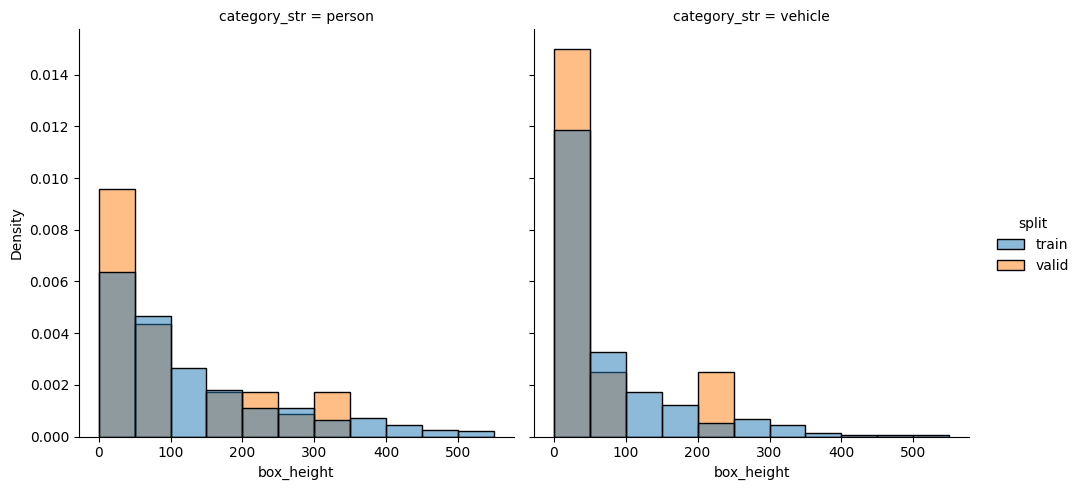

EMD and sinkhorn between target and train for box height : 0.0004139281770258621 0.05643086435154283
EMD and sinkhorn between target and valid for box height : 0.019769209734755263 0.06296603442654297


In [9]:
check_split_conformity(splitted_COCO_balanced_category)

Class repartition is almost perfect, but box height is still not perfect.

## Split while keeping box height balanced

Let's try to use that instead of "category_id"

In [10]:
box_height_group = grouper.ContinuousGroup("box_height", bins)

In [11]:
import warnings

warnings.filterwarnings("ignore")
splitted_COCO_balanced_height = COCO_SC.split(
    input_seed=1,
    split_names=["train", "valid"],
    target_split_shares=[0.1, 0.9],
    keep_separate_groups=["image_id"],
    keep_balanced_groups=[box_height_group],
    earth_mover_regularization=0,
)

Splitting annotations ...
Separating input data into atomic chunks
2699 chunks to distribute across 2 splits


  0%|          | 0/2699 [00:00<?, ?it/s]

Splitting images ...
Separating input data into atomic chunks
2301 chunks to distribute across 2 splits


  0%|          | 0/2301 [00:00<?, ?it/s]

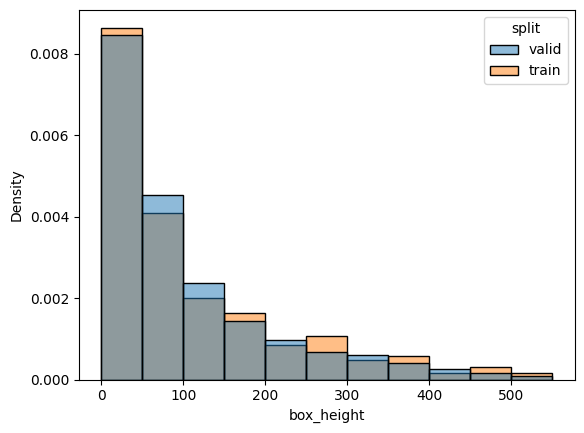

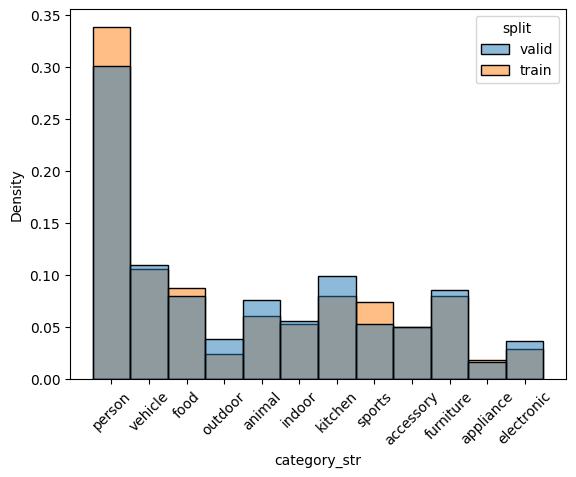

<Figure size 640x480 with 0 Axes>

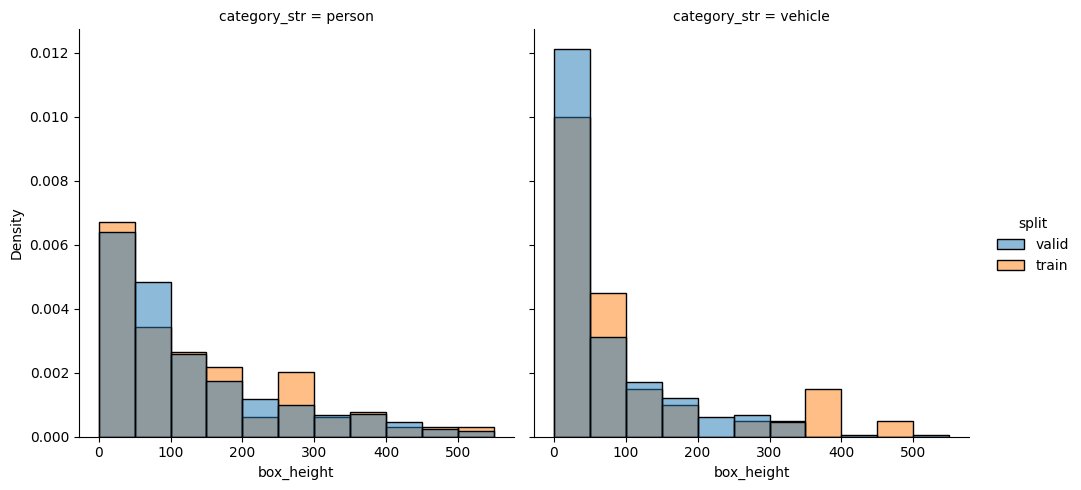

EMD and sinkhorn between target and train for box height : 0.013802532695916195 0.05937297935238999
EMD and sinkhorn between target and valid for box height : 0.001586449642183014 0.05644621532682227


In [12]:
check_split_conformity(splitted_COCO_balanced_height)

General box repartition is good, but not per class. Also, some class repartition is not good, e.g. `outdoor`.

## Split while keeping both categories and box height balanced

We can actually solve the problem by asking for balanced repartition for both classes and box heights.

In [13]:
splitted_COCO_balance_mixed = COCO_SC.split(
    input_seed=1,
    split_names=["train", "valid"],
    target_split_shares=[0.9, 0.1],
    keep_separate_groups=["image_id"],
    keep_balanced_groups=["category_id", box_height_group],
    earth_mover_regularization=0,
)

Splitting annotations ...
Separating input data into atomic chunks
2699 chunks to distribute across 2 splits


  0%|          | 0/2699 [00:00<?, ?it/s]

Splitting images ...
Separating input data into atomic chunks
2301 chunks to distribute across 2 splits


  0%|          | 0/2301 [00:00<?, ?it/s]

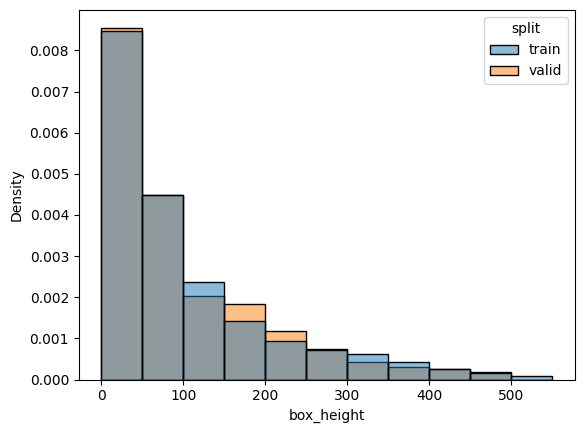

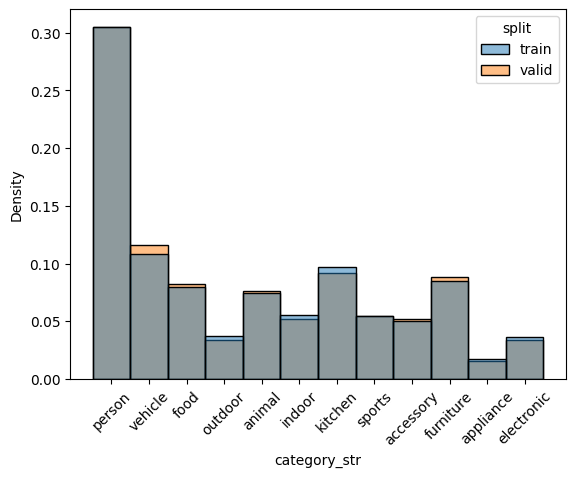

<Figure size 640x480 with 0 Axes>

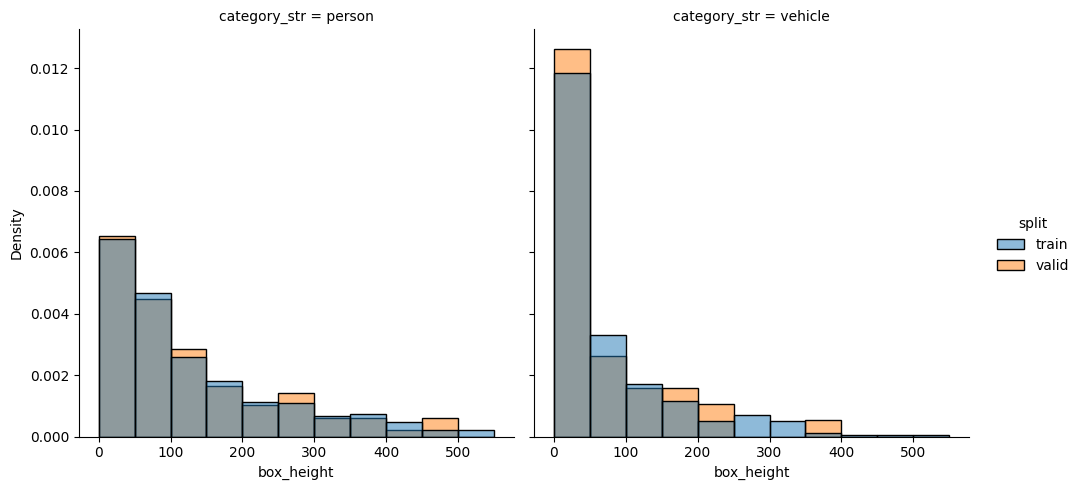

EMD and sinkhorn between target and train for box height : 0.0007947231394608702 0.05641936768280836
EMD and sinkhorn between target and valid for box height : 0.008147746155949598 0.05799456298767276


In [14]:
check_split_conformity(splitted_COCO_balance_mixed)